## Introduction

In the previous notebook, I went through the basics of Bayesian inference, and showed how each evidence affects the posterior distribution. This was done analytically using the fact that some likelihoods have a _conjugate prior_ allowing for a closed-form posterior. In most cases on the other hand, this is not possible. This is due to the denominator of Bayes rule, marginal distribution ($P(\boldsymbol{X})$), is not easily computable, and therefore the posterior cannot be found analytically.

Sometimes it is useful to try and lose some generalisation by forcing the likelihood into a known conjugate form, but often it is not possible. In these cases, we must therefore defer to sampling methods.

Two main sections: implementation, and explanation of burning (bottom of notebook)

_Note: this notebook also serves as practical introduction to the Julia language, and therefore there are several in-depth comments about common practice. You may skip those if you're not interested in the language_ 

## Monte Carlo Markov Chains for Sampling

Monte Carlo Markov Chains _(MCMC)_ are family of methods used to sample from a probability distribution without having a closed form. These were first created by physicists who needed to simulate gases in thermodynamic equilibrium. Long story short, they realised they didn't need to simulate the whole dynamics, but only needed to simulate some Markov chains having the same equilibrium distribution.

These methods later were found to be extremely useful in Bayesian inference, to sample from the posterior. The idea here is that the Markov chain has the same distribution as the posterior distribution, and therefore each step can be used as a sample of the posterior.

Sampling from the posterior then allows us to reconstruct it, or at least exctract information.

To do this, we must define a target distribution, $f(\theta)$, which is proportional to our posterior, and which is the distribution the Markov chain will set as its equilibrium. This is easily done by noticing that

$$ P(\theta | \boldsymbol{X}) = \frac{P(\boldsymbol{X}|\theta)P(\theta)}{P(\boldsymbol{X})} \propto P(\boldsymbol{X}|\theta)P(\theta) $$

We therefore set $f(\theta)$ to the right hand side, which we can compute.

## Metropolis Hastings Algorithm

Metropolis Hastings (MH) is a family of sampling algorithms connected by their sampling mechanism. To work, they require the target distribution $f(\theta)$, and a jump distribution $g(\theta' | \theta )$. 

They then follow a three step sampling, starting with some random initial condition $\theta$.
1. __Proposal:__ propose a new sample, $\theta'$, by picking from $g(\theta'|\theta)$
2. __Calculate:__ calculate the acceptance probability, as 
$$p = \min( 1, \frac{f(\theta')g(\theta'|\theta)}{f(\theta)g(\theta|\theta')} )$$
3. __Accept:__ accept new sample with probability p
    
Notice that this means that if $\theta'$ is "better" than $\theta$ with respect to the target distribution, it is automatically taken. Otherwise, it may still be taken with non-zero probability.

The Metropolis Algorithm is a special case of MH sampler, where the jump distribution is symmetric, that is $g(x|y) = g(y|x)$. Therefore, the acceptance probability simplifies to $\frac{f(\theta')}{f(\theta)}$.


## Implementation

In [59]:
using Distributions: Gamma, Distribution, Beta, pdf, Normal, Bernoulli, Logistic, logpdf
using Statistics, LaTeXStrings, Plots
pyplot()

""" 
    Julia is a language based on types instead of objects. It is therefore very useful to categorise your
    types (objects) into subtypes of abstract types.

    For instance in this case, MetropolisHastings define a generic "abstract" type. 
    Then we can make concrete types for all the MH algorithms.
"""
abstract type MetropolisHastings end

"""
    In Julia, there are two categories of concrete types, mutable and immutable. 
    Immutable do not change, they're pretty much constants, whereas mutables do.

    In this case, I've created a mutable structure, which is also parametric (see the "{T}"), with that
    same "T" being used to define the type of the internal θ variable. This means that I can call different 
    functions depending on the type of θ. In this case, we're gonna use it to differentiate between
    θ being a scalar, of a vector.
"""
mutable struct MetropolisAlgorithm{T} <: MetropolisHastings
    prior::Distribution
    likelihood::Function
    θ::T
end

"""
    Likelihood of a single observation. Just below, you can see the likelihood for many observations.
    It's good practice to separate the functions this way.
"""
function likelihood(sampler::MetropolisAlgorithm{T}, θ, χᵢ::T ) where T<:Number
    pdf(sampler.likelihood(θ), χᵢ)
end

function likelihood(sampler::MetropolisAlgorithm{T}, θ, χ::AbstractVector{T})  where T<:Number
    lh = 1.
    for χᵢ in χ
       lh *= likelihood(sampler, θ, χᵢ) 
    end
    lh
end

"""
    The jump distribution is simply defined as g(x) = normal(x,0.05)
"""
function proposal(sampler::MetropolisAlgorithm)
    rand(Normal(0.0,0.05))+sampler.θ
end

function acceptance_probability(sampler::MetropolisAlgorithm{T}, θ⁻::T, χ) where T<:Number
    θ = sampler.θ
    x  = pdf(sampler.prior, θ ) * likelihood(sampler, θ,  χ) 
    x⁻ = pdf(sampler.prior, θ⁻) * likelihood(sampler, θ⁻, χ)
    min(1., x⁻ / x)
end

function accept(sampler::MetropolisAlgorithm, ratio::AbstractFloat)
    c = rand()
    if c < ratio
        return true
    else
        return false
    end
end

""" The main sampling algorithm. Note: the "burned" parameter, will come back to it later """
function sample(sampler::MetropolisHastings, χ::Union{AbstractVector, AbstractMatrix}; 
                max_iterations=100, burned=20)
    
    samples = []
    
    for t in 1:max_iterations
        
        θ⁻ = proposal(sampler)
        ratio = acceptance_probability(sampler, θ⁻, χ)
        
        if accept(sampler, ratio)
            sampler.θ = θ⁻
            if t > burned
               push!(samples,copy(θ⁻))
            end           
        end
    end
    
    samples
end

sample (generic function with 2 methods)

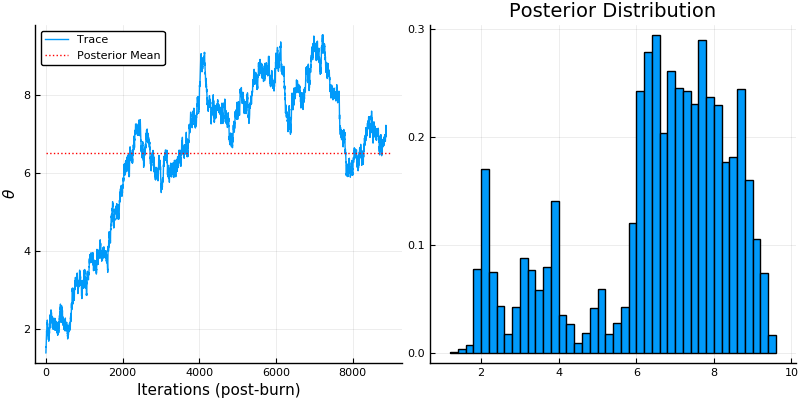

In [60]:
interval = -5.:0.01:20.

prior = Gamma(4.0,1.0)
likelihood_function(x) = Logistic(x,3)
ground_truth = 9.0
X = rand(likelihood_function(ground_truth),10)

sampler = MetropolisAlgorithm(prior, likelihood_function, 0.5)
samples = sample(sampler, X; max_iterations=10_000, burned=1_000)

μ, σ = mean(samples), std(samples)

fig1 = plot(samples, ylabel=L"\theta", xlabel="Iterations (post-burn)", label="Trace")
plot!([0,9000], [μ, μ], style=:dot, color=:red, label="Posterior Mean")

fig2 = histogram(samples, normed=true, title="Posterior Distribution", legend=false)

plot(fig1, fig2, layout=(1,2), size=(800,400))

As we can see, the ground_truth is set to 9.0, which is likely (depending on the run) to be quite far from the predicted number. This is due to two reasons: 
1. The MCMC has not converged. This is quite clear in this case, since we expect the chain to look much more like a Browinian motion around some value.
2. The evidencce is probably not enough.

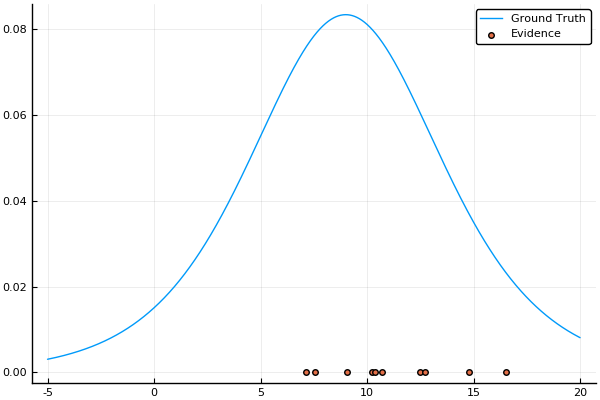

In [38]:
plot(interval, pdf.(likelihood_function(ground_truth), interval), label="Ground Truth")
scatter!(X, zeros(10), label="Evidence")

It is clear there isn't enough evidence to correctly infer $\theta$.

Let us therefore, add more evidence...

... well it turns out if you try to do this, you're very likely to get an error related to division by zero.

If you look back at the likelihood equations, you'll notice the term `lh *= likelihood(..)`. Now these likelihoods are all smaller than one, and if you start multiplying numbers smaller than one together, you're quickly going to get _underflow_, which happens when the number is too small and is approximated to zero.

To fix this, we're simply going to _log_ the whole equations, and exponentiate again at the acceptance probability calculation.

In [61]:
function likelihood(sampler::MetropolisAlgorithm{T}, θ, χ::AbstractVector{T})  where T<:Number
    log_lh = 0.
    for χᵢ in χ
       log_lh += log( likelihood(sampler, θ, χᵢ) )
    end
    log_lh
end


function acceptance_probability(sampler::MetropolisAlgorithm{T}, θ⁻::T, χ) where T<:Number
    θ = sampler.θ
    # Note: logpdf instead of pdf
    x  = logpdf(sampler.prior, θ ) + likelihood(sampler, θ,  χ)
    x⁻ = logpdf(sampler.prior, θ⁻) + likelihood(sampler, θ⁻, χ)
    # Note: substraction (log-space division) and then exponential
    min(1., exp(x⁻ - x))
end

acceptance_probability (generic function with 1 method)

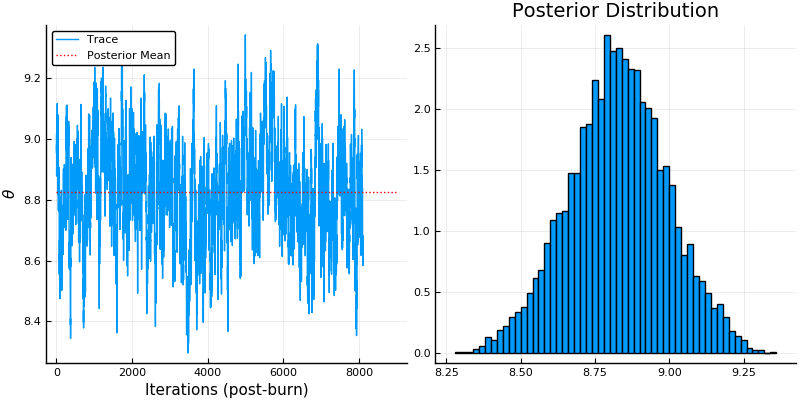

In [58]:
X = rand(likelihood_function(ground_truth),1000)

sampler = MetropolisAlgorithm(prior, likelihood_function, 0.5)
samples = sample(sampler, X; max_iterations=10_000, burned=1_000)

μ, σ = mean(samples), std(samples)

fig1 = plot(samples, ylabel=L"\theta", xlabel="Iterations (post-burn)", label="Trace")
plot!([0,9000], [μ, μ], style=:dot, color=:red, label="Posterior Mean")

fig2 = histogram(samples, normed=true, title="Posterior Distribution", legend=false)

plot(fig1, fig2, layout=(1,2), size=(800,400))

Magic! The trace looks good, the posterior looks good.. It worked!

## Burning: why?

Throughout this exercise, I've put a burning phase, during which samples were not recorded. It may not be evident why this is the case, so let me clarify why using a single plot:

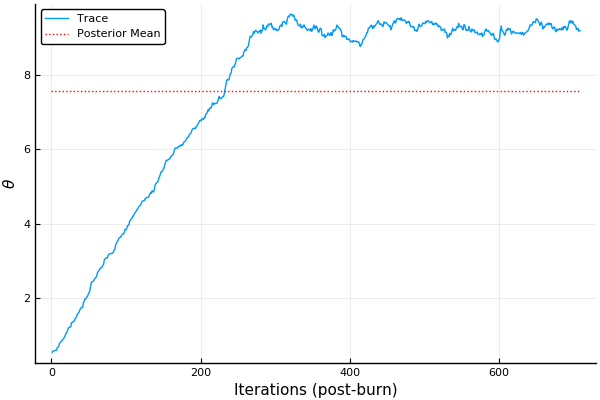

In [64]:
X = rand(likelihood_function(ground_truth),1000)

sampler = MetropolisAlgorithm(prior, likelihood_function, 0.5)
samples = sample(sampler, X; max_iterations=1000, burned=0)

μ, σ = mean(samples), std(samples)

fig1 = plot(samples, ylabel=L"\theta", xlabel="Iterations (post-burn)", label="Trace")
plot!([0,size(samples,1)], [μ, μ], style=:dot, color=:red, label="Posterior Mean")

Huh.. interesting.. So what happened?

Well as mentioned earlier, we're following a Markov chain. This Markov chain has the same equilibrium distribution as our target distribution.

One important word: equilibrium. This implies the chain has reached some stationary state if you want, but we must give it time to reach it. That's what burning is for. As we can see in the plot above, the trace consistently increases up to iteration $\approx 200$, where it starts moving up and down around. That's when you know you've reached the equilibrium state, and that you're ready to actually sample the data.


However, usually sampling is done over several dimensions, in which such a trace is not interpretable. Therefore, it is usually left at the discretion of the experiments to find automatically find when this burning is done, or to simply overestimate the number of iterations required, and burn everything beforehand (usually the prefered choice due to simplicity)